## Towards a new standard for seismic moment tensor inversion containing 3D Earth structure uncertainty 

*T.-S. Phạm, H. Tkalčić, J. Hu, and S. Kim*

May 2024

This notebook contains scripts to reproduce figures published in the associating paper published in Geophysical Journal International. 

In [2]:
# Loading necessary packages and setting up the environment
%config InlineBackend.figure_format = "retina"
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from hashlib import md5
from mpl_toolkits.basemap import Basemap
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['font.size'] = 9

%load_ext autoreload
%autoreload 2

In [3]:
# Loading user-defined function
from helper import read_3d_model, read_station_info, plot_3d_model
from MainMTI import *
from helper import plot_lune_frame, mt2lune

2024-05-16 22:46:56.111654: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 22:46:56.912231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Random perturbation of 3D Earth models

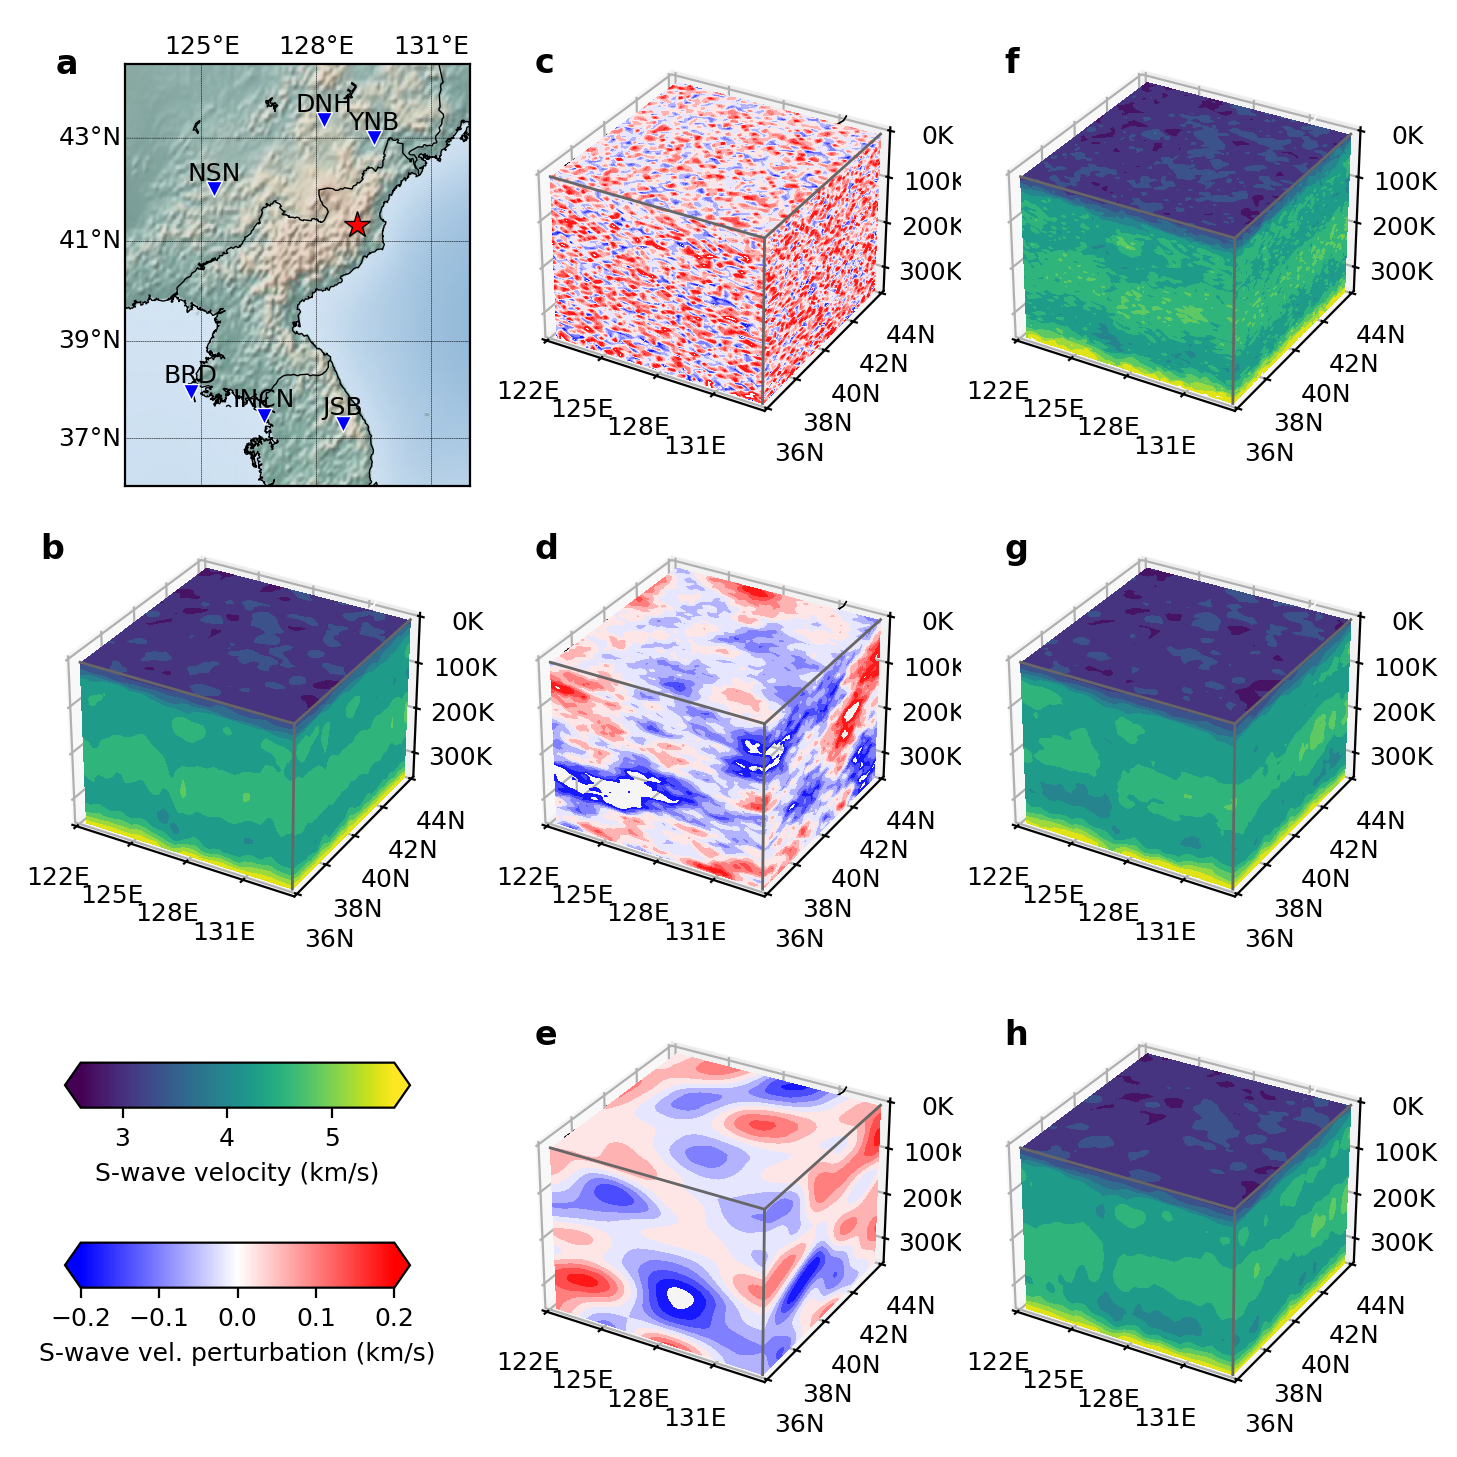

In [4]:
def PlotModelRandomPerturbation(root_dnames, fig_fname=None):
    ### Create a figure with 3D ax
    X, Y, Z, ref_model3d = read_3d_model()

    fig = plt.figure(figsize=(7.5, 7.5))
    gs = fig.add_gridspec(3, 3, left=0., right=0.92, wspace=0.07, bottom=0.05, top=1.0, hspace=0.07)
    label_kw = dict(xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')

    for d in range(len(root_dnames)):
        root_path = Path(root_dnames[d])
        ax = fig.add_subplot(gs[d, 1], projection='3d')
        # a random perturbed model
        _, _, _, ran_model3d = read_3d_model(root_path/'MODEL001')
        # plot redidual model
        plot_3d_model(ax, X, Y, Z, ran_model3d-ref_model3d, kw1, line_kw1)
        ax.annotate('%c'%(99+d), xy=(0.1,0.9), **label_kw)
        # plot perturbed model
        ax = fig.add_subplot(gs[d, 2], projection='3d')
        plot_3d_model(ax, X, Y, Z, ran_model3d, kw0, line_kw0)
        ax.annotate('%c'%(99+len(root_dnames)+d), xy=(0.1,0.9), **label_kw)

    # orignal modellv88
    ax = fig.add_subplot(gs[1, 0], projection='3d')
    ax.annotate('b', xy=(0.1,0.9), ha='right', **label_kw)
    plot_3d_model(ax, X, Y, Z, ref_model3d, kw0, line_kw0)
            
    ####### LOCATION MAP
    ax = fig.add_axes([0.07, 0.65, 0.23, 0.35])
    ax.annotate('a', xy=(-0.2, 1), **label_kw)
    bm = Basemap(projection='merc',resolution=bm_resolution,ax=ax,
                 llcrnrlat=36,urcrnrlat=44.4,
                 llcrnrlon=123,urcrnrlon=132)
    bm.shadedrelief()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawcountries(linewidth=0.5)
    bm.drawparallels(range(33,46,2),labels=(1,0,0,0),linewidth=.2,dashes=(3,1))
    bm.drawmeridians(range(122,133,3),labels=(0,0,1,0),linewidth=.2,dashes=(3,1))
    # stations
    stat_list = read_station_info(STMASK)
    stla = [s['stla'] for s in stat_list]
    stlo = [s['stlo'] for s in stat_list]
    xx,yy = bm(stlo,stla)
    ax.plot(xx, yy, 'v', c='b', mec='w', mew=.5)
    for i in range(len(stat_list)):
        ax.text(xx[i], yy[i]+25e3, stat_list[i]['name'], ha='center')
    xx, yy = bm(129.049, 41.320)
    ax.plot(xx,yy,'*', c='r', mec='k', mew=.5, ms=10)

    ####### COLORMAP LEGEND
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(kw0['vmin'], kw0['vmax']), cmap=kw0['cmap']), 
                 orientation='horizontal', label='S-wave velocity (km/s)', extend='both',
                 cax=fig.add_axes([0.03, 0.27, 0.23, 0.03]))
    
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(kw1['vmin'], kw1['vmax']), cmap=kw1['cmap']), 
                 orientation='horizontal', label='S-wave vel. perturbation (km/s)', extend='both',
                 cax=fig.add_axes([0.03, 0.15, 0.23, 0.03]))

    ## Save figure
    if fig_fname is not None: plt.savefig(fig_fname, dpi=300)
    plt.show()

if __name__ == '__main__':
    # universal parameters
    kw0 = {'vmin': 2.6,'vmax': 5.6,'levels': np.linspace(2.6, 5.6, 11), 'cmap':'viridis'}
    line_kw0 = {'linewidth': .5, 'color': 'w'}
    kw1 = {'vmin': -.2,'vmax': .2,'levels': np.linspace(-.2, .2, 11),'cmap': 'bwr'}
    line_kw1 = {'linewidth': .5, 'color': 'k'}
    bm_resolution='i'
    # set of models to show
    root_dnames = ['ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/3',
                   'ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/2',
                   'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2']
    PlotModelRandomPerturbation(root_dnames, 'Figure1.pdf')

**Figure 1.** Reference velocity model in 3D and random perturbations. a) A map of the Korean peninsula shows the configuration of the synthetic seismic source (red star) and seismic stations (blue triangles). The seismic source is fixed at 5 km depth in this study. b) The 3D shear-wave velocity model of the Korean Peninsula constructed from ambient noise tomography (Kim et al. 2016) is used as the reference velocity model, representing the knowledge of Earth’s structure in the region. Panels c), d), and e) show three representative examples of random small-scale perturbations drawn from uncorrelated, exponential, and Gaussian distributions of structural errors. The perturbations are added to the reference model to simulate randomly perturbed models shown in panels f), g), and h).  

### Construction of structural covariance matrices

NameError: name 'wlen' is not defined

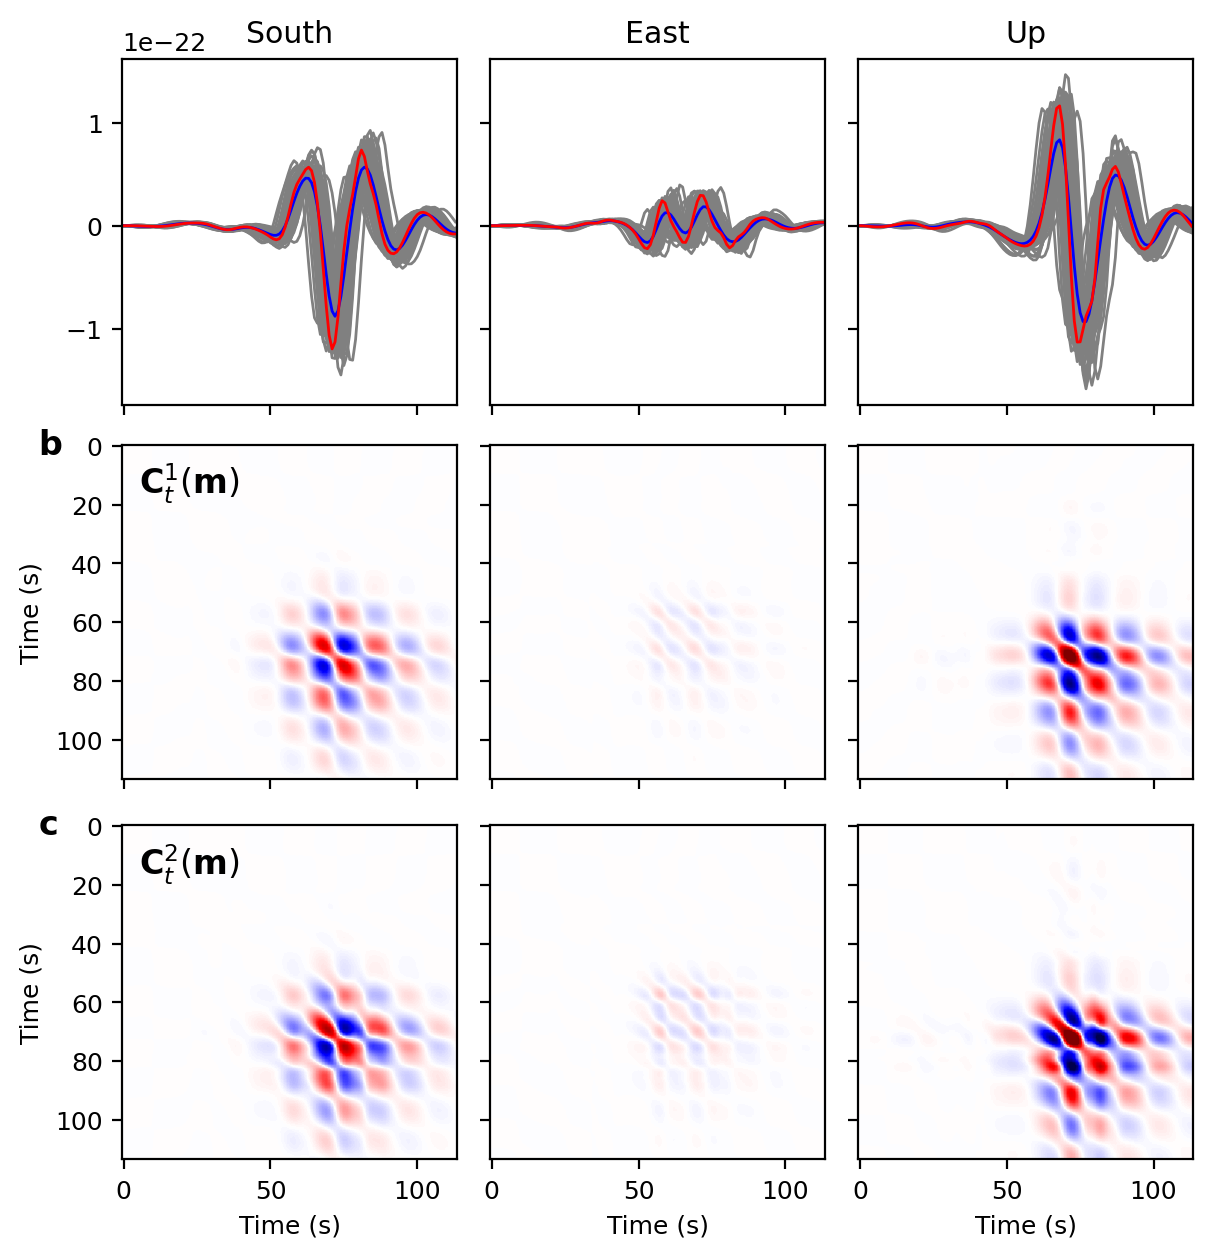

In [5]:
def PlotStrucCovMat(config_path, fig_fname=None):
    ## Reference models of the known velocity models
    gtensor_ref = LoadSES3DGTensor('ses3d_r07_b', VRED, T0, WLEN)
    gtensor_ref = gtensor_ref[STMASK, :, :, :-1]
    
    ## Green's functions of randomised Earth's structures
    gtensors = LoadSES3DGTensorInBulk(Path(config_path), VRED, T0, WLEN)
    gtensors = gtensors[:,STMASK,:,:,:-1]
    nm, ns, nc, ne, nt = gtensors.shape

    ## structral uncertainty covariance matrices
    Cov1_t = CalcTheoCov(M6_TRUE, gtensors)
    Cov2_t = CalcTheoCov(M6_TRUE, gtensors, gtensor_ref)
    fig, ax = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(6.3,7),
                            gridspec_kw={'hspace': 0.1, 'wspace': 0.1, 'left': 0.1, 'right': 0.95, 'top': 0.95, 'bottom': 0.16})
    for c in range(nc):
        vmax = np.max(np.abs(Cov1_t[0, 0]))*1.5
        ax[1,c].imshow(Cov1_t[0, c],vmin=-vmax,vmax=vmax,cmap='seismic')
        ax[2,c].imshow(Cov2_t[0, c],vmin=-vmax,vmax=vmax,cmap='seismic')
    ax[1,0].set(ylabel='Time (s)')
    ax[1,0].annotate(r'$\mathbf{C}_t^1(\mathbf{m})$', xy=(0.05, 0.95), xycoords='axes fraction', va='top', fontsize=12)
    ax[1,0].annotate('b', xy=(-0.25, 1), xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')
    ax[2,0].set(ylabel='Time (s)')
    ax[2,0].annotate(r'$\mathbf{C}_t^2(\mathbf{m})$', xy=(0.05, 0.95), xycoords='axes fraction', va='top', fontsize=12)
    ax[2,0].annotate('c', xy=(-0.25, 1), xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')
    ## ensemble of synthetic seismograms
    titles = ['South','East','Up']
    syn = M6_TRUE @ gtensors
    ref = M6_TRUE @ gtensor_ref
    mean = np.mean(syn, axis=0)
    tvec = np.arange(nt)
    for c in range(nc):
        for m in range(nm): ax[0,c].plot(tvec, syn[m,0,c], lw=1, c='gray', label=('$m\cdot G_i$' if m==0 else None))
        ax[0,c].plot(tvec, mean[0,c], lw=1, c='b', label='$m\cdot \widebar{G}$')
        ax[0,c].plot(tvec, ref[0,c], lw=1, c='r', label='$m\cdot \widehat{G}$')
        ax[0,c].set(title=titles[c])
        ax[2,c].set(xlabel='Time (s)')
    ax[0,0].set(xlim=(0, wlen), ylabel='Velocity (m/s)')
    ax[0,0].legend(loc='lower left', fontsize=7)
    ax[0,0].annotate('a', xy=(-0.25, 1), xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')
    
    ## axis for colorbars
    cax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
    cb = mpl.colorbar.ColorbarBase(cax, cmap='seismic', norm=mpl.colors.Normalize(vmin=-vmax, vmax=vmax), orientation='horizontal')
    cb.set_label('Covariance amplitude (m$^2$/s$^2$)')
    ## Save figure
    if fig_fname is not None: plt.savefig(fig_fname, dpi=300)
    plt.show()
    
if __name__ == '__main__':
    PlotStrucCovMat('ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2', 'Figure3.pdf')

**Figure 3.** Estimation of the structural covariance matrices from simulated waveform ensembles for Earth models perturbed by Gaussian distribution, = 2%. a) The gray lines in each panel show ensembles of 49 waveforms to station NSN (see Fig. 1a) simulated by an identical seismic source in randomly perturbed 3D Earth models. Red lines are the mean of the waveform ensembles corresponding to perturbed models, shown in gray, and blue lines are waveforms simulated in the reference velocity model. b) and c) are the covariance matrices relative to the mean waveform, denoted as, in Eq. (10) and the reference model’s waveforms, denoted as , in Eq. (11) (see Section 2.3 for more details).

### Comparison of inversion methods

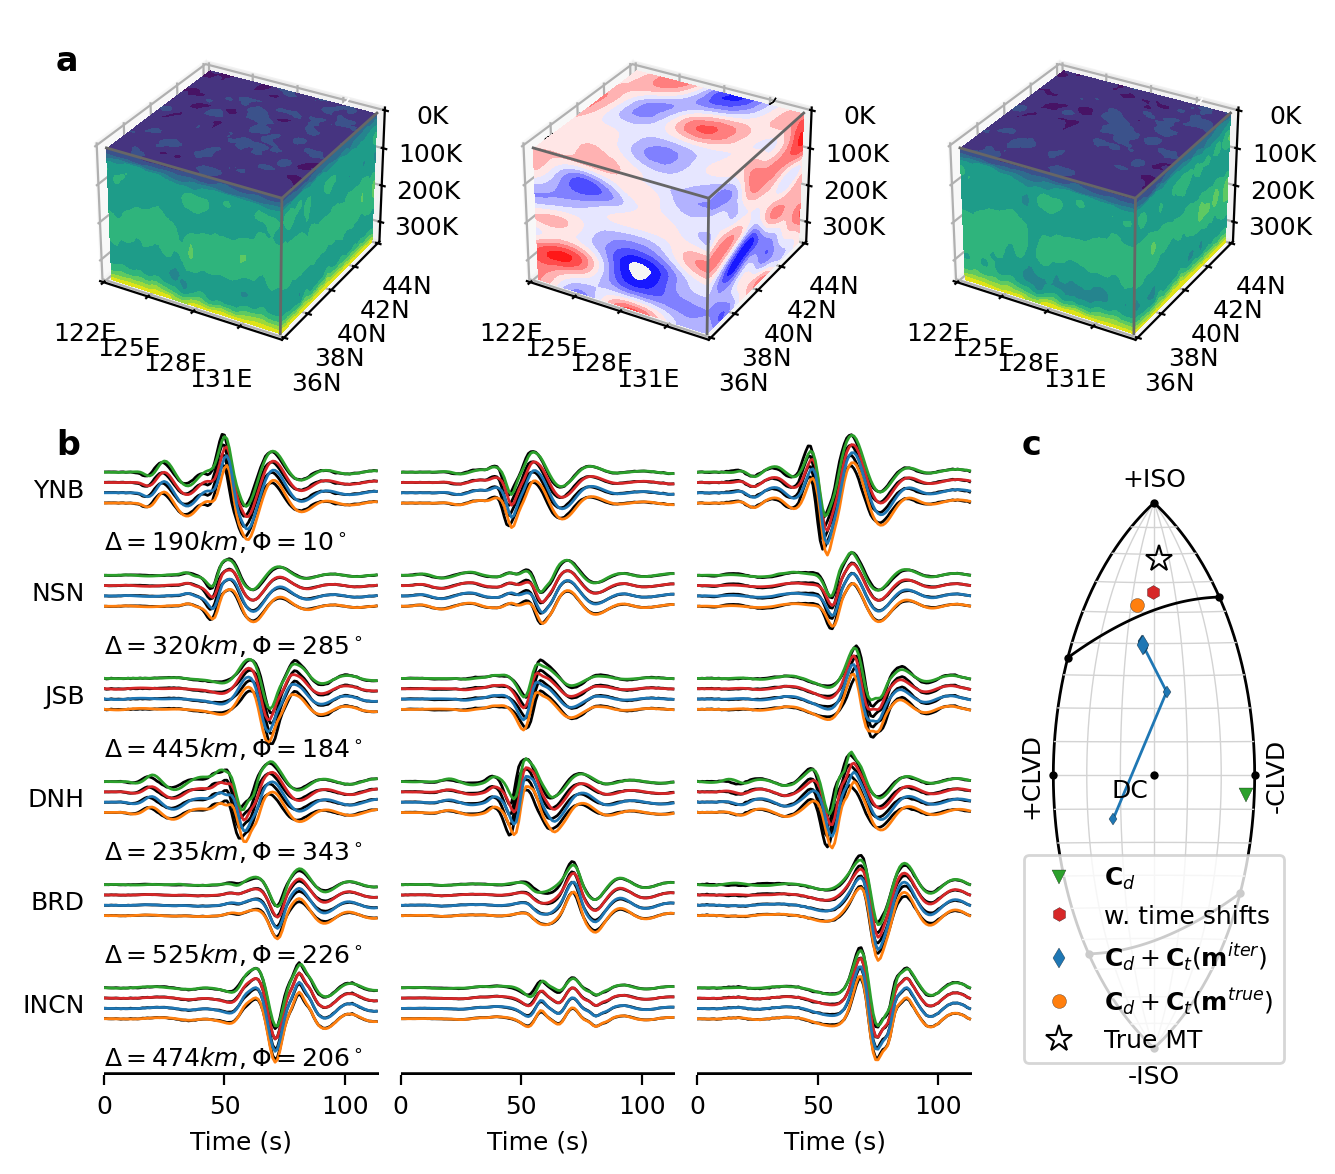

In [ ]:
def plot_solutions_on_lune(ax, sol_dict, lune_kw=None):
    ax.set(frame_on=False, xticks=[], yticks=[])
    bm = plot_lune_frame(ax, **lune_kw)

    for key, val in sol_dict.items():
        m6_sol = val['mt_sol']
        lon, lat = mt2lune(m6_sol[...,0], m6_sol[...,1], m6_sol[...,2], 
                           m6_sol[...,3], m6_sol[...,4], m6_sol[...,5])
        x,y = bm(lon,lat)
        ax.plot(x, y, **val['sol_kw'])
        
def Figure_Method_Comparison(config_path, model_idx=0):
    ## Reference models of the known velocity models
    gtensor_ref = LoadSES3DGTensor('ses3d_r07_b', VRED, T0, WLEN)
    gtensor_ref = gtensor_ref[STMASK, :, :, :-1]
    
    ## Green's functions of randomised Earth's structures
    gtensors = LoadSES3DGTensorInBulk(Path(config_path), VRED, T0, WLEN)
    gtensors = gtensors[:,STMASK,:,:,:-1]
    _, ns, nc, _, nt = gtensors.shape

    ## Generate synthetic seismograms with uncorrelated data noise
    m6_true = np.array([.9, .8, .7, -.3, .2, .1])
    obs = m6_true @ gtensors
    noise_std = np.std(obs, axis=-1) * 0.02
    obs += np.einsum('msct,msc->msct',np.random.normal(0,1,obs.shape),noise_std)

    results = SolveSuite(gtensor_ref, obs[model_idx], noise_std[model_idx], gtensors, 
                         inversion_types=dict(wu_strucerror={'n_iters':10, 'return_chain':True},
                                          w_strucerror={'m6_true':m6_true},
                                          wo_strucerror={},
                                          w_timeshift={'learning_rate':2e-1, 'epochs':500}))
    m6_sol_wu_strucerror = results['wu_C1_strucerror']
    m6_sol_w_strucerror = results['w_C1_strucerror']
    m6_sol_wo_strucerror = results['wo_strucerror']
    m6_sol_w_timeshift = results['w_timeshift']

    ## 3D Earth model for reference
    X, Y, Z, ref_model3d = read_3d_model()
    _, _, _, ran_model3d = read_3d_model(Path(config_path)/'MODEL001')

    ## FIGURE INITIATION
    pred_wo_strucerror = m6_sol_wo_strucerror @ gtensor_ref
    pred_w_strucerror = m6_sol_w_strucerror @ gtensor_ref
    pred_wu_strucerror = m6_sol_wu_strucerror[-1] @ gtensor_ref
    pred_w_timeshift = m6_sol_w_timeshift @ gtensor_ref
    gridspec_kw={'top':0.65, 'bottom':0.10, 'left':0.10, 'right':0.72, 'wspace':0.08}
    fig, axarr = plt.subplots(1, 3, figsize=(7, 6), gridspec_kw=gridspec_kw, sharex=True, sharey=True)
    scale = .7 / np.max(np.abs(obs))
    stat_list = read_station_info(STMASK)
    for c in range(nc):
        axarr[c].set(frame_on=False)
        for s in range(ns):
            ## synthetic observation
            data = obs[model_idx, s, c]*scale
            tvec = np.arange(nt)
            for _ in (-.15, -.05, .05, .15):
                axarr[c].plot(tvec, data+s+_, lw=1, c='k')
            ## predicted waveforms with structural error
            data = pred_w_strucerror[s, c]*scale
            axarr[c].plot(tvec, data+s-.15, lw=1, c='C1')
            ## predicted waveform with time shift
            data = pred_w_timeshift[s, c]*scale
            axarr[c].plot(tvec, data+s+.05, lw=1, c='C3')
            ## predicted waveforms without structural error
            data = pred_wo_strucerror[s, c]*scale
            axarr[c].plot(tvec, data+s+.15, lw=1, c='C2')
            ## predicted waveforms with unknown structural error
            data = pred_wu_strucerror[s, c]*scale
            axarr[c].plot(tvec, data+s-.05, lw=1, c='C0')
            ## station information 
            if c==0:masktat_list[s]['dist'], stat_list[s]['azim'])
                axarr[c].annotate(txt, xy=(0, s-.4), va='top')
        ## axes annotation
        axarr[c].plot([0, nt], [-.7,-.7], lw=2, c='k')
        axarr[c].set(xlabel='Time (s)')
        axarr[c].tick_params(left=False)
    axarr[0].set(xlim=(0, nt), ylim=(-.7, 5.7), yticks=range(6), yticklabels=[stat['name'] for stat in stat_list])
        
    ## Plot solutions
    ax = fig.add_axes([0.75, 0.1, 0.2, 0.5])
    ax.set(frame_on=False, xticks=[], yticks=[])
    bm = plot_lune_frame(ax)
    
    #solution without strucerror
    lon, lat = mt2lune(m6_sol_wo_strucerror[0], m6_sol_wo_strucerror[1], m6_sol_wo_strucerror[2], 
                       m6_sol_wo_strucerror[3], m6_sol_wo_strucerror[4], m6_sol_wo_strucerror[5])
    x,y = bm(lon,lat)
    ax.plot(x, y, ms=5, mew=.1, c='C2', mec='k', marker= 'v', lw=0, label=r'$\mathbf{C}_d$')
    # solution with time shift
    lon, lat = mt2lune(m6_sol_w_timeshift[0], m6_sol_w_timeshift[1], m6_sol_w_timeshift[2],
                        m6_sol_w_timeshift[3], m6_sol_w_timeshift[4], m6_sol_w_timeshift[5])
    x,y = bm(lon,lat)
    ax.plot(x, y, ms=5, mew=.1, c='C3', mec='k', marker= 'h', lw=0, label='w. time shifts')
    #solution with unknown strucerror
    lon, lat = mt2lune(m6_sol_wu_strucerror[:,0], m6_sol_wu_strucerror[:,1], m6_sol_wu_strucerror[:,2], 
                       m6_sol_wu_strucerror[:,3], m6_sol_wu_strucerror[:,4], m6_sol_wu_strucerror[:,5])
    x,y = bm(lon,lat)
    ax.plot(x, y, '-d', ms=3, lw=1, c='C0', mec='k', mew=.1)#, label='$C_d + C_t(m^p)$')
    ax.plot(x[-1], y[-1], ms=5, c='C0', mew=.1, mec='k', marker= 'd', lw=0, label=r'$\mathbf{C}_d + \mathbf{C}_t(\mathbf{m}^{iter})$')
    #solution with well-known strucerror
    lon, lat = mt2lune(m6_sol_w_strucerror[0], m6_sol_w_strucerror[1], m6_sol_w_strucerror[2], 
                       m6_sol_w_strucerror[3], m6_sol_w_strucerror[4], m6_sol_w_strucerror[5])
    x,y = bm(lon,lat)
    ax.plot(x, y, ms=5, mew=.1, c='C1', mec='k', lw=0, marker= 'o', label=r'$\mathbf{C}_d + \mathbf{C}_t(\mathbf{m}^{true})$')
    
    ## TRUE MT SOLUTION
    lon0, lat0 = mt2lune(m6_true[0], m6_true[1], m6_true[2], m6_true[3], m6_true[4], m6_true[5])
    x, y = bm(lon0, lat0)
    ax.plot(x, y, '*', c='none', mec='k', mew=.75, ms=10, label='True MT')
    handles, labels = ax.get_legend_handles_labels()
    unique_handles, unique_labels = [], []
    for h, l in zip(handles,labels):
        if l not in unique_labels:
            unique_handles.append(h)
            unique_labels.append(l)
    ax.legend(unique_handles, unique_labels, loc='lower center')
    ## VELOCITY MODEL FOR REFERENCE
    gridspec_kw={'top':0.98, 'bottom':0.68, 'left':0.05, 'right':0.95, 'wspace':0.05}
    gs = fig.add_gridspec(1, 3, **gridspec_kw)
    ax = fig.add_subplot(gs[0], projection='3d')
    plot_3d_model(ax, X, Y, Z, ref_model3d, kw0, line_kw0)
    ax = fig.add_subplot(gs[1], projection='3d')
    plot_3d_model(ax, X, Y, Z, ran_model3d-ref_model3d, kw1, line_kw1)
    ax = fig.add_subplot(gs[2], projection='3d')
    plot_3d_model(ax, X, Y, Z, ran_model3d, kw0, line_kw0)
    
    ax.annotate('a', xy=(0.04, 0.92), xycoords='figure fraction', fontsize=12, fontweight='bold')
    ax.annotate('b', xy=(0.04, 0.6), xycoords='figure fraction', fontsize=12, fontweight='bold')
    ax.annotate('c', xy=(0.73, 0.6), xycoords='figure fraction', fontsize=12, fontweight='bold')
    
    ## SAVE FIGURE
    plt.show()

if __name__ == '__main__':
    Figure_Method_Comparison('ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2')

**Figure. 4** Examples of inverted MT solutions under three inversion assumptions for a highly isotropic MT input. a) The 3D shear-wave velocity models include the reference velocity model (Kim et al. 2016), , a Gaussian structural error, , and the perturbed velocity model, , playing the role of the true Earth model (see Fig. 1). b) Synthetic waveform data with added white noise, plotted in black lines, correspond to the true Earth model, . Predicted waveforms shown in colored lines correspond to three four MT solutions  whose source types are plotted in the lune diagramtypes given different assumptions on the uncertainty covariance matrices. c) Source types of MAP solutions optimally recovered with the following covariance matrices: data noise covariance matrix only, ; structural covariance matrix computed with the true MT input, Cd+Ct(mtrue); structural covariance matrix estimated iteratively, (Phạm & Tkalčić 2021). In the iterative case, we plot the trajectory of MT solutions iterated fives time from a random initial prior solution. The red hexagon shows the MT source type jointly inverted with station-specific time shifts (Phạm 2024). 

### Source types of tested moment tensors

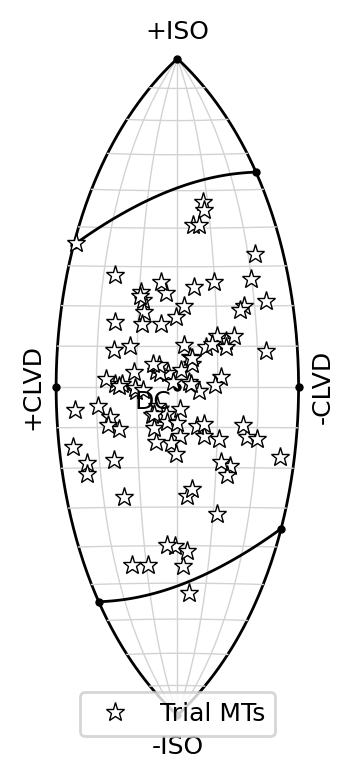

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
ax.set(frame_on=False, xticks=[], yticks=[])
bm = plot_lune_frame(ax)
x, y = bm(*mt2lune(M6_TRUE_ARRAY[:, 0], M6_TRUE_ARRAY[:, 1], M6_TRUE_ARRAY[:, 2], 
                   M6_TRUE_ARRAY[:, 3], M6_TRUE_ARRAY[:, 4], M6_TRUE_ARRAY[:, 5]))
ax.plot(x, y, '*', ms=7, lw=0, c='w', mec='k', mew=.5, label='Trial MTs')
ax.legend(loc='lower center')
plt.tight_layout()
plt.savefig('Figure6.pdf', dpi=300)
plt.show()

**Figure 6.** Source types of 100 random input MTs for repeated inversions, whose results are summarised in Figs. 8, 10, and 12.

In [ ]:
def PlotInversionAssumptionTests(config_paths, m6_true):
    ## Read the reference 3D model
    X, Y, Z, ref_model3d = read_3d_model()
    ## Create figure frames    
    fig = plt.figure(figsize=(7.5, 5.5))
    gs_mods = fig.add_gridspec(1, 3, top=1.0, bottom=0.62, left=0.02, right=0.98, wspace=0.1)
    gs_sols = fig.add_gridspec(1, 3, top=0.67, bottom=0.0, left=0.05, right=0.98, wspace=0.2) 
    ## Loop through types of perturbations
    for c in range(3):
        ## Read an instance of the perturbed model
        root_path = Path(config_paths[c])
        _, _, _, ran_model3d = read_3d_model(root_path/'MODEL001')
        ## Read the inversion results
        fname = md5(json.dumps([str(root_path), tuple(m6_true)]).encode('utf-8')).hexdigest()
        with open(test1_dname/fname, 'rb') as f: 
            tmp = pickle.load(f)
            sol_dict = {key: {'mt_sol': np.array([res[key] for res in tmp])} for key in tmp[0].keys()}
        ## Define perturbation type name
        tokens = config_paths[c].split('/')
        title = '%s/%s' % (tokens[-2][:-3], tokens[-1]) + '%'
        ## Plot the random perturbation
        ax = fig.add_subplot(gs_mods[c], projection='3d')
        plot_3d_model(ax, X, Y, Z, ran_model3d-ref_model3d, kw1, line_kw1)
        ax.annotate(title, xy=(1, 1), xycoords='axes fraction', va='top', ha='right')
        sol_dict['wo_strucerror']['sol_kw'] = dict(marker='v', c='C2', mec='k', mew=.1, ms=5, lw=0,
                                                label=r'$\mathbf{C}_d$')
        sol_dict['w_timeshift']['sol_kw'] = dict(marker='h', c='C3', mec='k', mew=.1, ms=5, lw=0, 
                                                label=r'w. time shifts')
        sol_dict['wu_C1_strucerror']['sol_kw'] = dict(marker='d', c='C0', mec='k', mew=.1, ms=5, lw=0,
                                                label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{iter})$'%1)
        sol_dict['w_C1_strucerror']['sol_kw']  = dict(marker='o', c='C1', mec='k', mew=.1, ms=3, lw=0,
                                                label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{true})$'%1)
        sol_dict['wu_C2_strucerror']['sol_kw'] = dict(marker='d', c='C0', mec='k', mew=.1, ms=5, lw=0,
                                                label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{iter})$'%2)
        sol_dict['w_C2_strucerror']['sol_kw']  = dict(marker='o', c='C1', mec='k', mew=.1, ms=3, lw=0,
                                                label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{true})$'%2)
        sol_dict['mt_true'] = dict(mt_sol=m6_true, sol_kw=dict(marker='*', c='w', mec='k', mew=.75, 
                                                            ms=10, lw=0, label='True MT'))
        ## Plot the solutions
        gs = gs_sols[c].subgridspec(1, 2, wspace=0.)
        ax1, ax2 = [fig.add_subplot(_) for _ in gs]
        sol_dict1 = {key:sol_dict[key] for key in ['wo_strucerror', 'wu_C1_strucerror', 'w_C1_strucerror', 'mt_true']}
        plot_solutions_on_lune(ax1, sol_dict1, lune_kw=dict(clvd_right=False))
        if c == 0: ax1.legend(loc='lower center', fontsize=6.5)
        sol_dict1 = {key:sol_dict[key] for key in ['w_timeshift', 'wu_C2_strucerror', 'w_C2_strucerror', 'mt_true']}
        plot_solutions_on_lune(ax2, sol_dict1, lune_kw=dict(clvd_left=False))
        if c == 0: ax2.legend(loc='lower center', fontsize=6.5)
        ax1.annotate(f'{c+97:c}', xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold', va='top')
    plt.show()
    plt.close(fig)

def PlotIntegrationTests(config_paths):
    ## Organiza data for plots
    gathered_dict = dict()
    
    for perturb_type in config_paths:
        for strucerror in ['wu_C1_strucerror', 'w_C1_strucerror', 'wu_C2_strucerror', 'w_C2_strucerror']:
            fname = md5(json.dumps(str(perturb_type)).encode('utf-8'))
            fname = test2_dname/fname.hexdigest()
            with open(fname, 'rb') as f: results = pickle.load(f)
            dist_by_model = []
            for model_idx in range(49):
                tmp = []
                for m6, val in results.items():
                    lon0, lat0 = _mt2lune(np.array(m6))
                    lon, lat = _mt2lune(val[model_idx][strucerror])
                    tmp.append(locations2degrees(lat0, lon0, lat, lon))
                dist_by_model.append(tmp)
            gathered_dict[(perturb_type, strucerror)] = np.array(dist_by_model)
    
    ####### Plot figure
    fig, ax = plt.subplots(len(root_dnames), 2, figsize=(7.5, 7.5), sharex=True, sharey=True)

    for use_Ct_prime in range(2):
        sol_kw = {f'wu_C{use_Ct_prime+1}_strucerror': dict(capsize=2, elinewidth=1, fmt='d', c='C0', mec='k', mew=.75, ms=3, 
                                        label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{iter})$'%(use_Ct_prime+1)),
                  f'w_C{use_Ct_prime+1}_strucerror':  dict(capsize=2, elinewidth=1, fmt='o', c='C1', mec='k', mew=.75, ms=3, 
                                        label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{true})$'%(use_Ct_prime+1))}
        for _ipath, root_path in enumerate(config_paths):
            x = ax[_ipath, use_Ct_prime]
            for strucerror in [f'wu_C{use_Ct_prime+1}_strucerror', f'w_C{use_Ct_prime+1}_strucerror']:
                tmp = gathered_dict[(root_path, strucerror)]
                mean_dist = np.median(tmp, axis=1)
                # yerr = np.std(tmp, axis=0)
                yerr = np.percentile(tmp, [5, 95], axis=1)
                # yerr = [np.min(tmp, axis=0), np.max(tmp, axis=0)]
                shifted = ('wu' in strucerror) / 3
                x.errorbar(np.arange(len(mean_dist))+shifted, mean_dist, yerr=yerr, \
                           **sol_kw[strucerror])
                med_dist = np.median(mean_dist)
                x.axhline(med_dist, color=sol_kw[strucerror]['c'], lw=1)
        ax[0, use_Ct_prime].legend(loc='upper left')
        ax[_ipath, use_Ct_prime].set(xlabel='True Earth model index')

    for _ipath in range(len(config_paths)): 
        ax[_ipath, 0].set(ylabel='Distance to true MT ($^\circ$)')
        ax[_ipath, 0].annotate('%c'%(97+_ipath), xy=(-.1, 1.05), xycoords='axes fraction',
                                    ha='right', fontweight='bold', fontsize=12)
        tokens = config_paths[_ipath].split('/')
        title = '%s/%s' % (tokens[-2][:-3], tokens[-1]) + '%'
        ax[_ipath, 0].set_title(title, loc='left')
        ax[_ipath, 0].set(xlim=(-1, len(mean_dist)))

    for x in ax.flatten(): 
        x.grid(ls='-', lw=.2, c='gray')
        x.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    fig.tight_layout()
    plt.show()

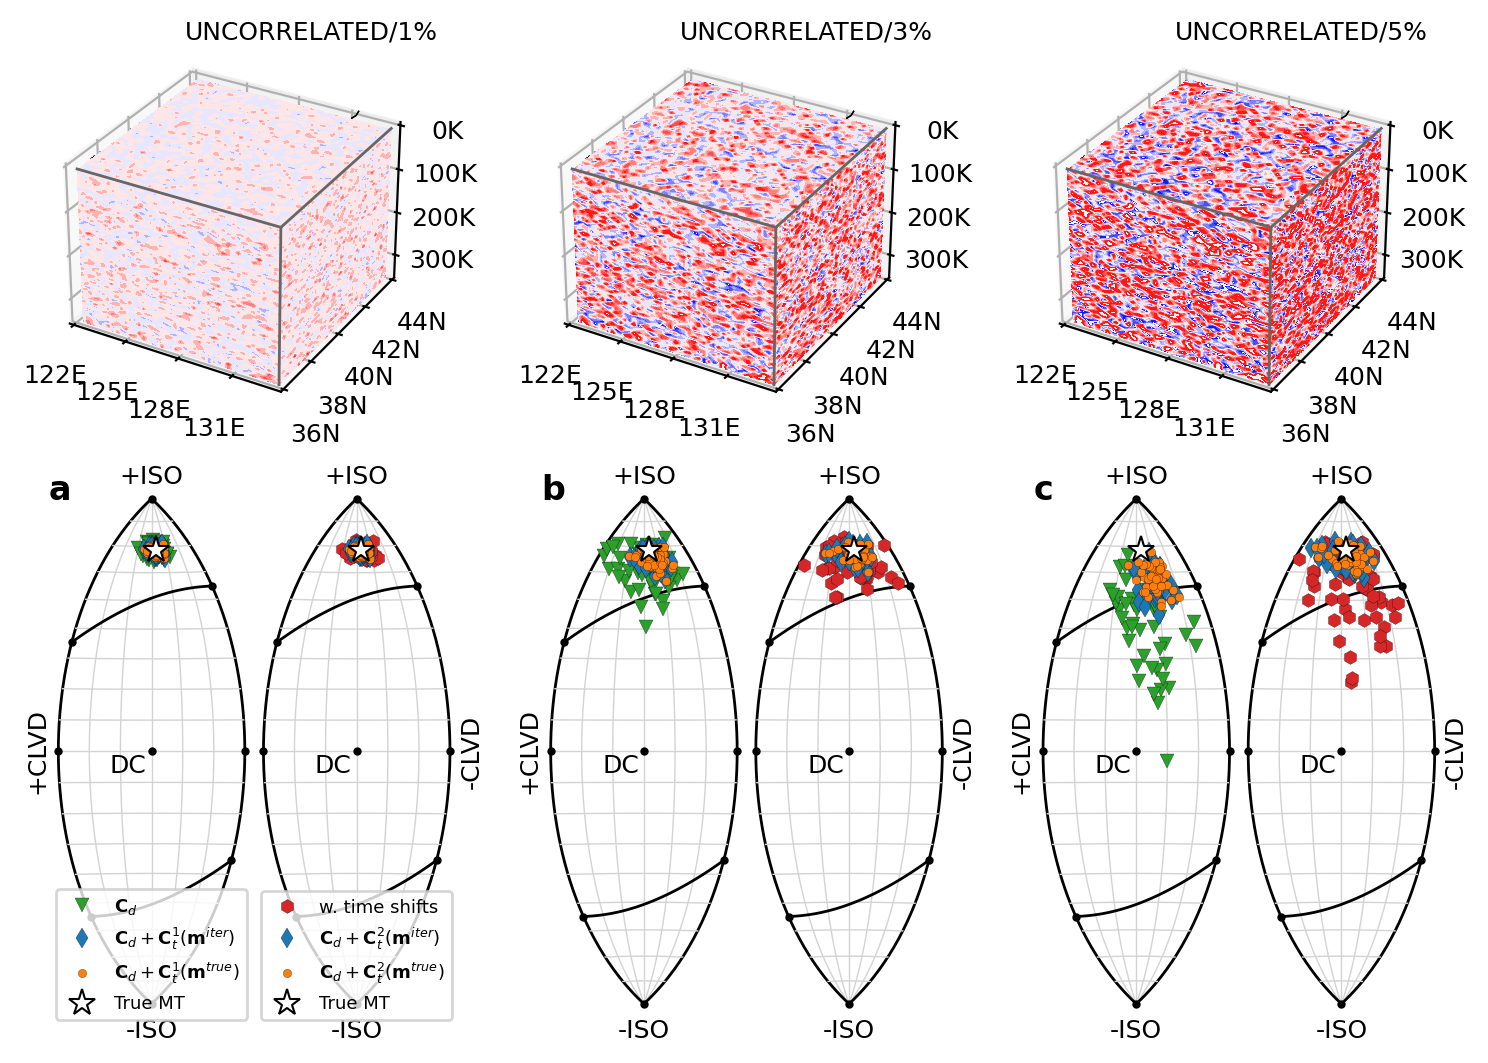

In [ ]:
def _mt2lune(m6): return mt2lune(m6[...,0], m6[...,1], m6[...,2], m6[...,3], m6[...,4], m6[...,5])

PlotInversionAssumptionTests(CONFIG_PATHS[0:3], M6_TRUE)

**Figure 7.** MT inversion results in uncorrelated structural error. As signposted in Fig. 4, the top row shows examples of uncorrelated structural errors for 1%, 3%, and 5% perturbations, and panels a), b), and c) show inversion results for the perturbation magnitudes. In each of the panels, the left lune diagram shows the inversion results using C1t(m), relative to the mean ensemble waveforms in Eq. (10), while the right-hand side lune diagram employs C2t(m), relative to the reference model’s waveforms in Eq. (11). Each lune diagram compares MT solutions corresponding to three inversion assumptions. Green triangles are solutions when only the data noise covariance matrix is considered,. Red hexagons are solutions jointly inverted with station-specific time shifts as a practical means to account for structural error (see Section 2.5 for details). Blue diamonds are the solution when the structural covariance matrix is defined iteratively, Cd+Ct(miter). The orange dots are structural covariance matrix computed with the input MT, Cd+Ct(mtrue) (see Section 2.3 for more details). 

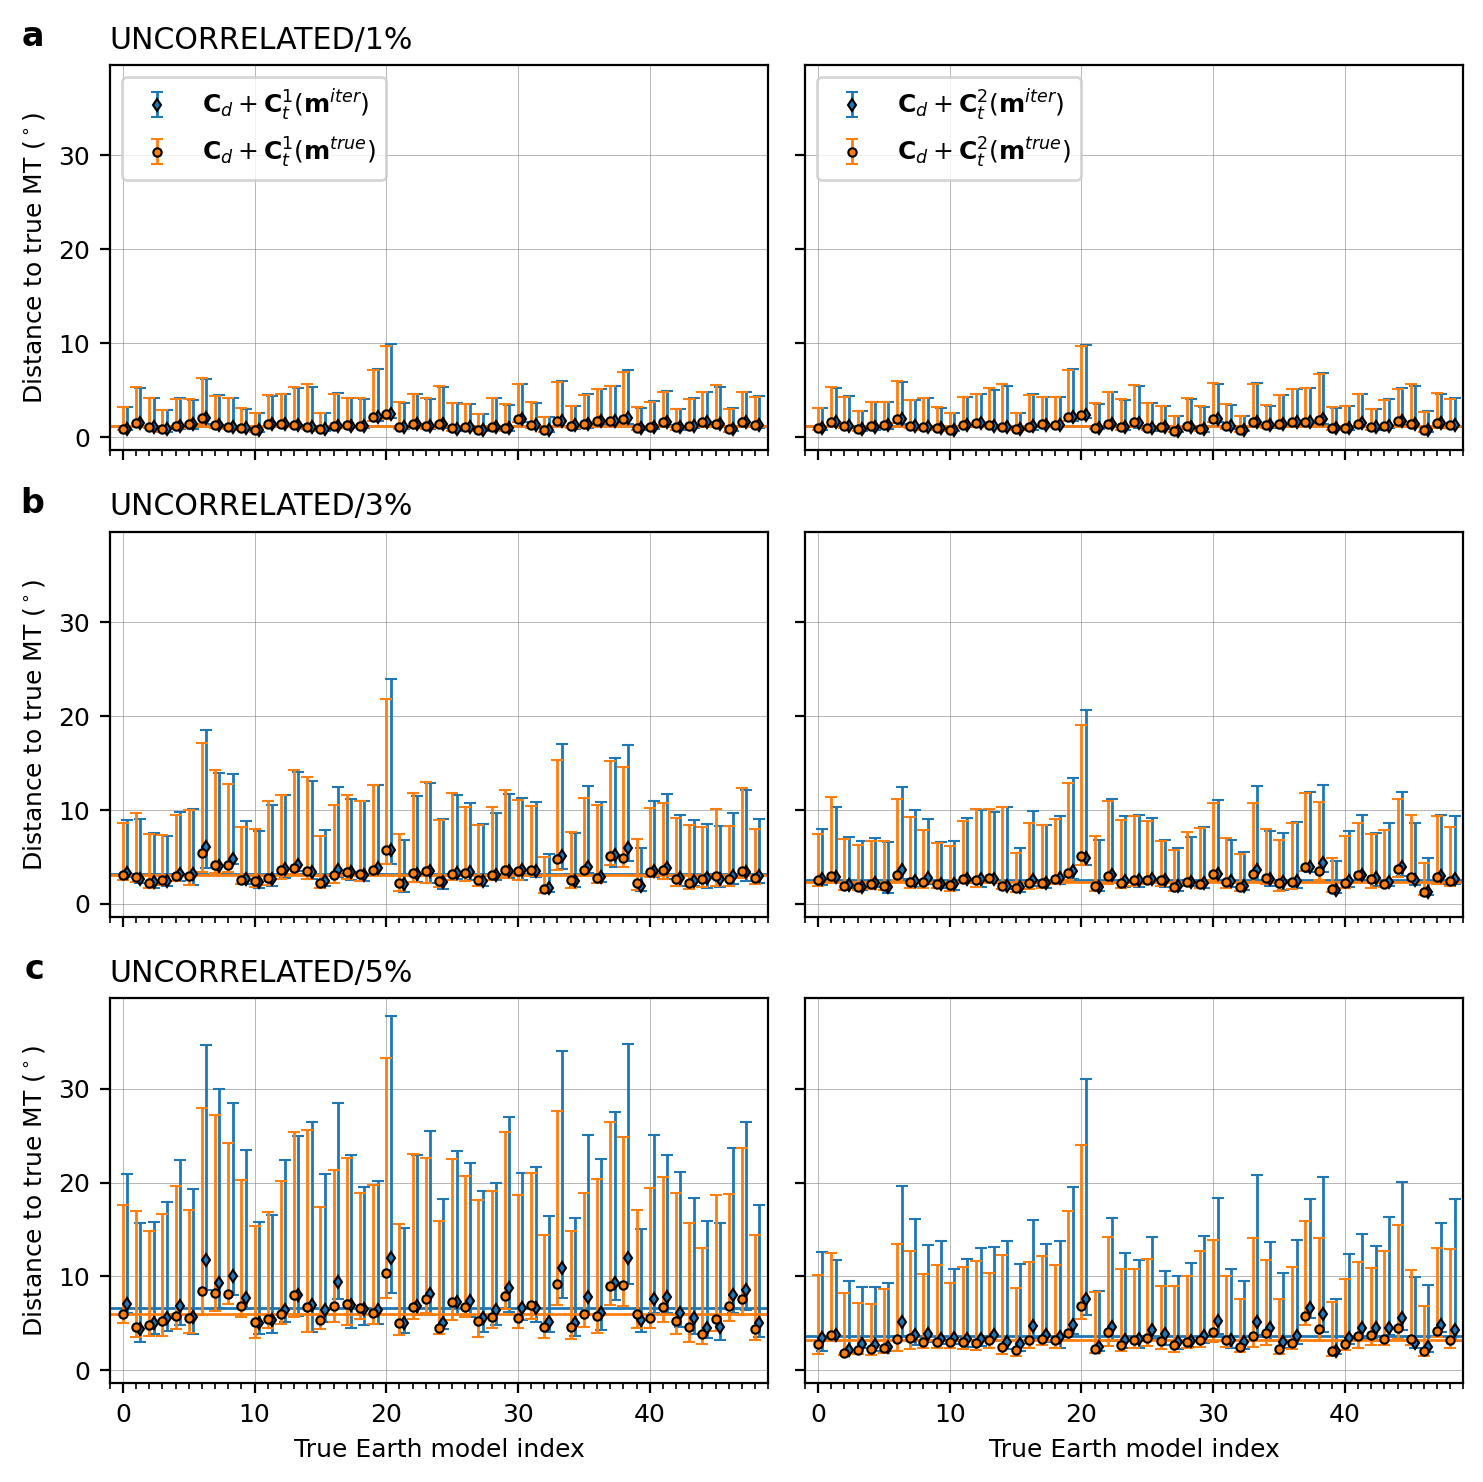

In [ ]:
PlotIntegrationTests(CONFIG_PATHS[0:3])

**Figure 8.** Statistical comparisons of MT solutions recovered with different inversion assumptions for uncorrelated structural error. Panels a), b), and c) correspond to uncorrelated structural errors of 1%, 3%, and 5%, as featured in Fig. 5. Their left- and right-hand side sub-panels correspond to the use of C1t and C2t, respectively. In each sub-panel, results are plotted along the horizontal axis as a function of model indices in the perturbed ensemble playing the role of the actual Earth structure. The vertical axis shows the angular distance from the recovered solutions to the true MT in the lune coordinates of source types. Each data point and error bar show the median and the 5–95 percentiles of the angular distances when repeating the inversion for 50 true MTs.  

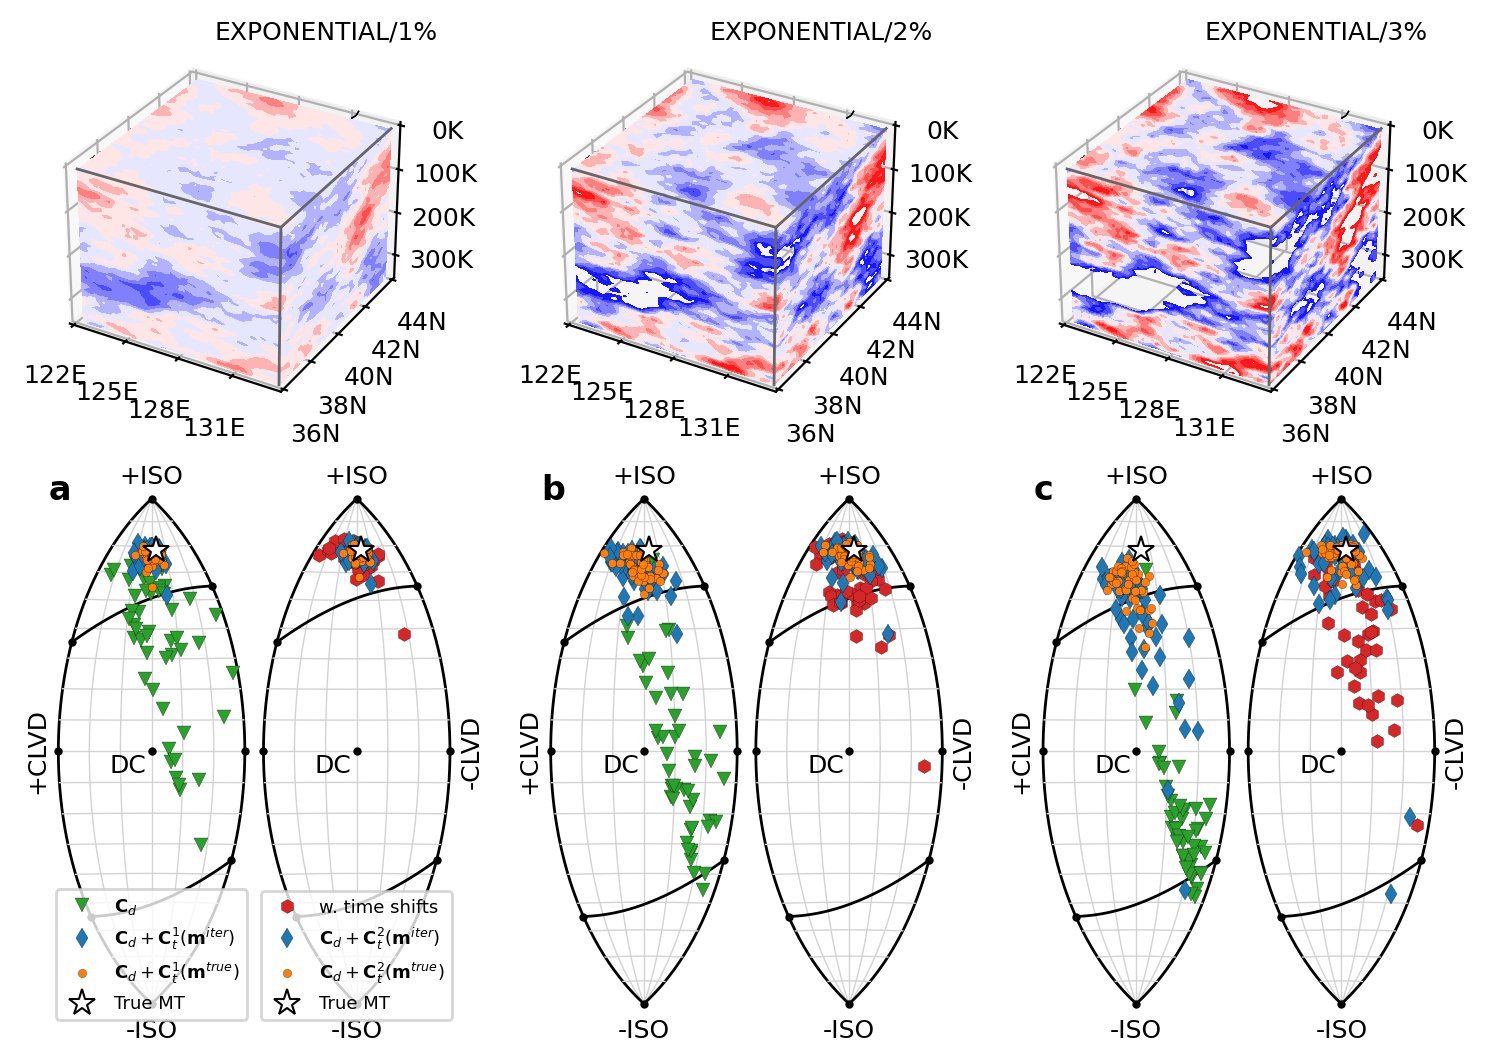

In [ ]:
PlotInversionAssumptionTests(CONFIG_PATHS[3:6], M6_TRUE)

**Figure 9.** This figure shows the results of a similar analysis as in Fig. 7 but for exponential structural error (Eq. (7)). 

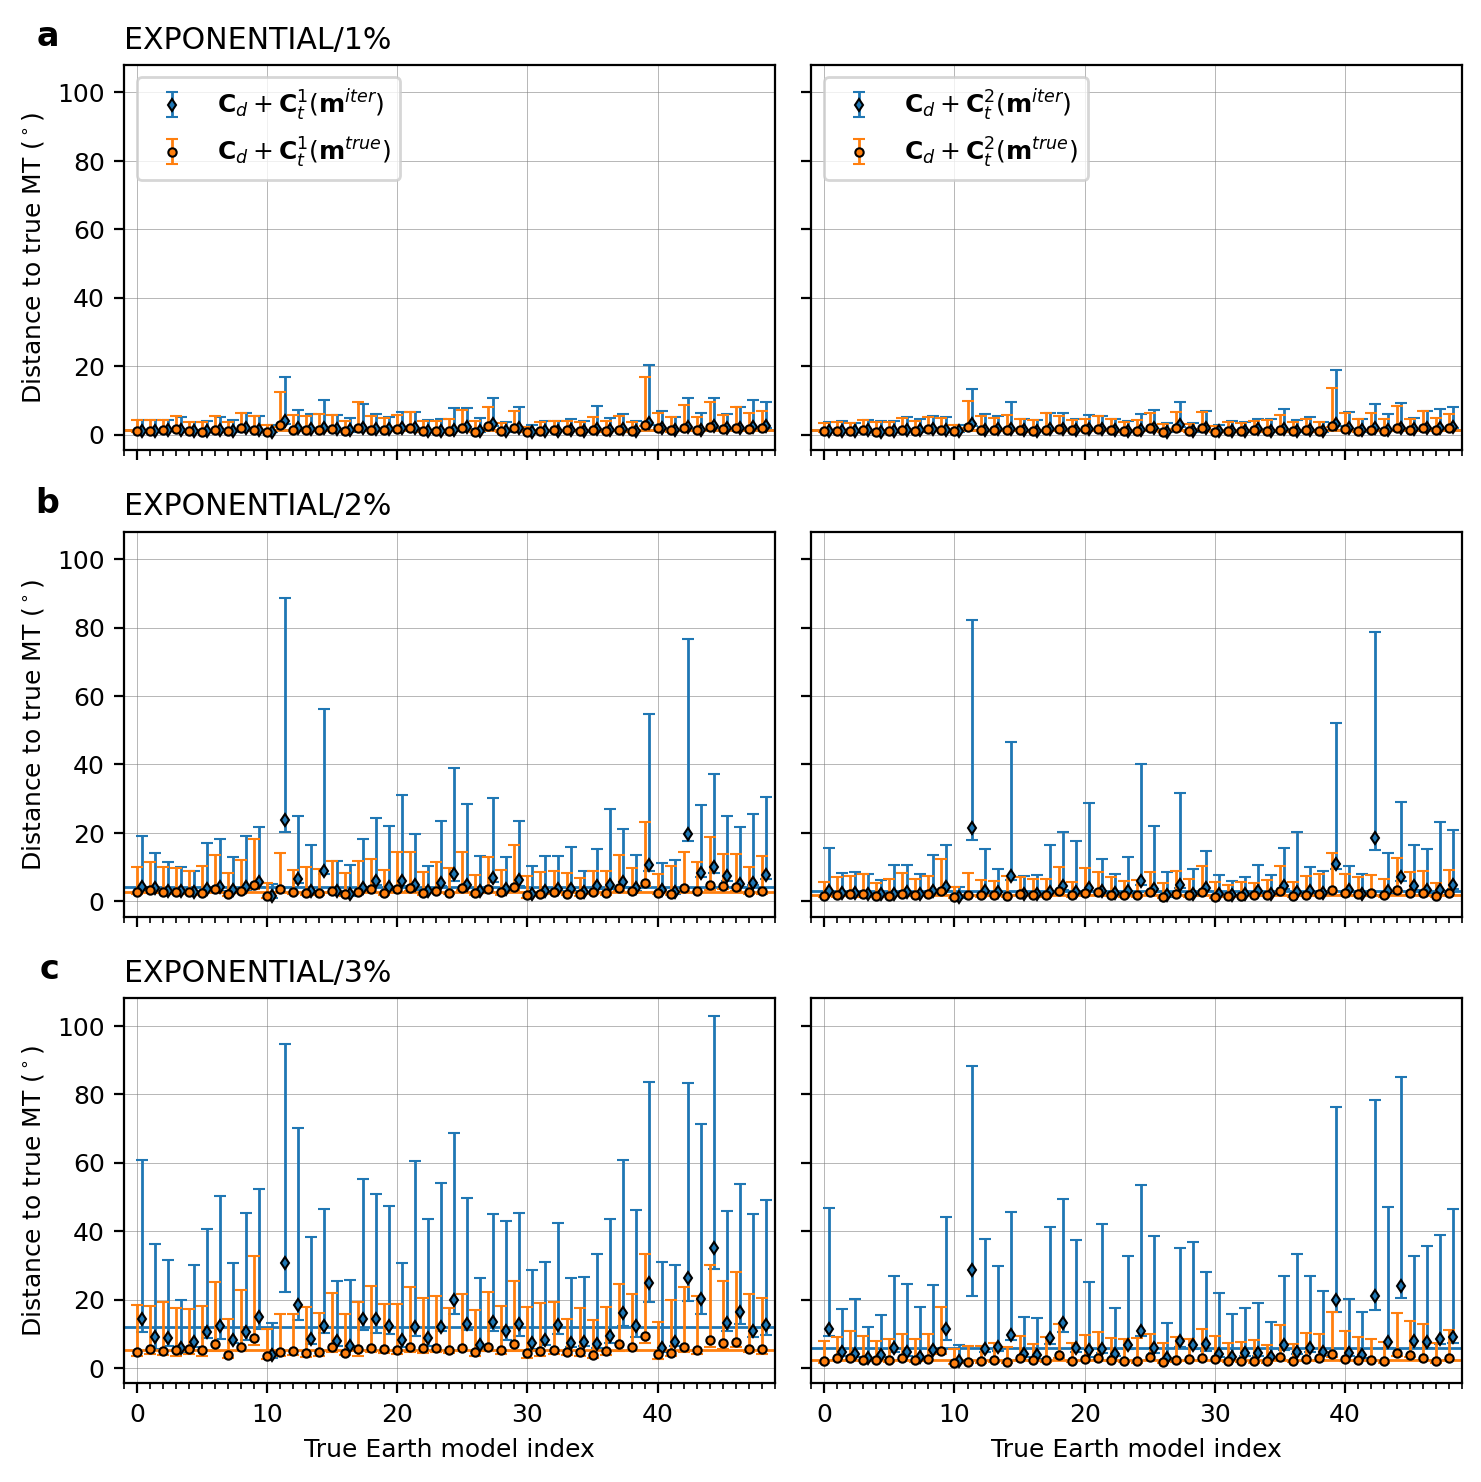

In [ ]:
PlotIntegrationTests(CONFIG_PATHS[3:6])

**Figure 10.** This figure shows the results of a similar analysis as in Fig. 8 but for exponential structural error. 

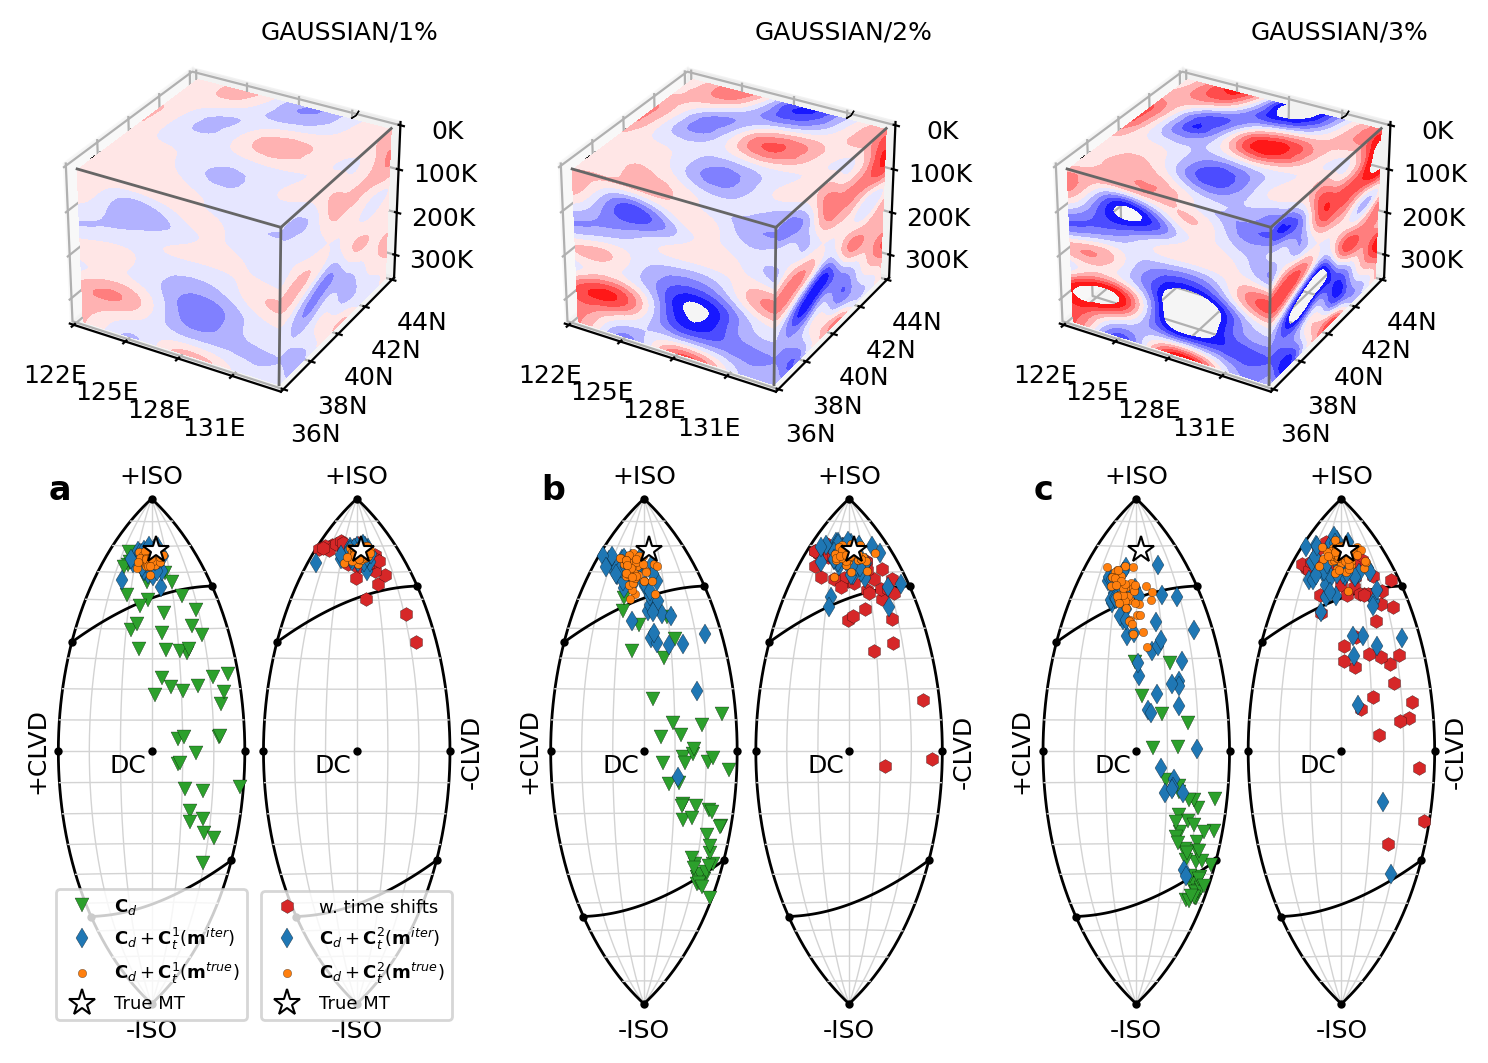

In [ ]:
PlotInversionAssumptionTests(CONFIG_PATHS[6:9], M6_TRUE)

**Figure 11.** This figure shows the results of a similar analysis as in Fig. 7 but for Gaussian structural error (Eq. (8)).

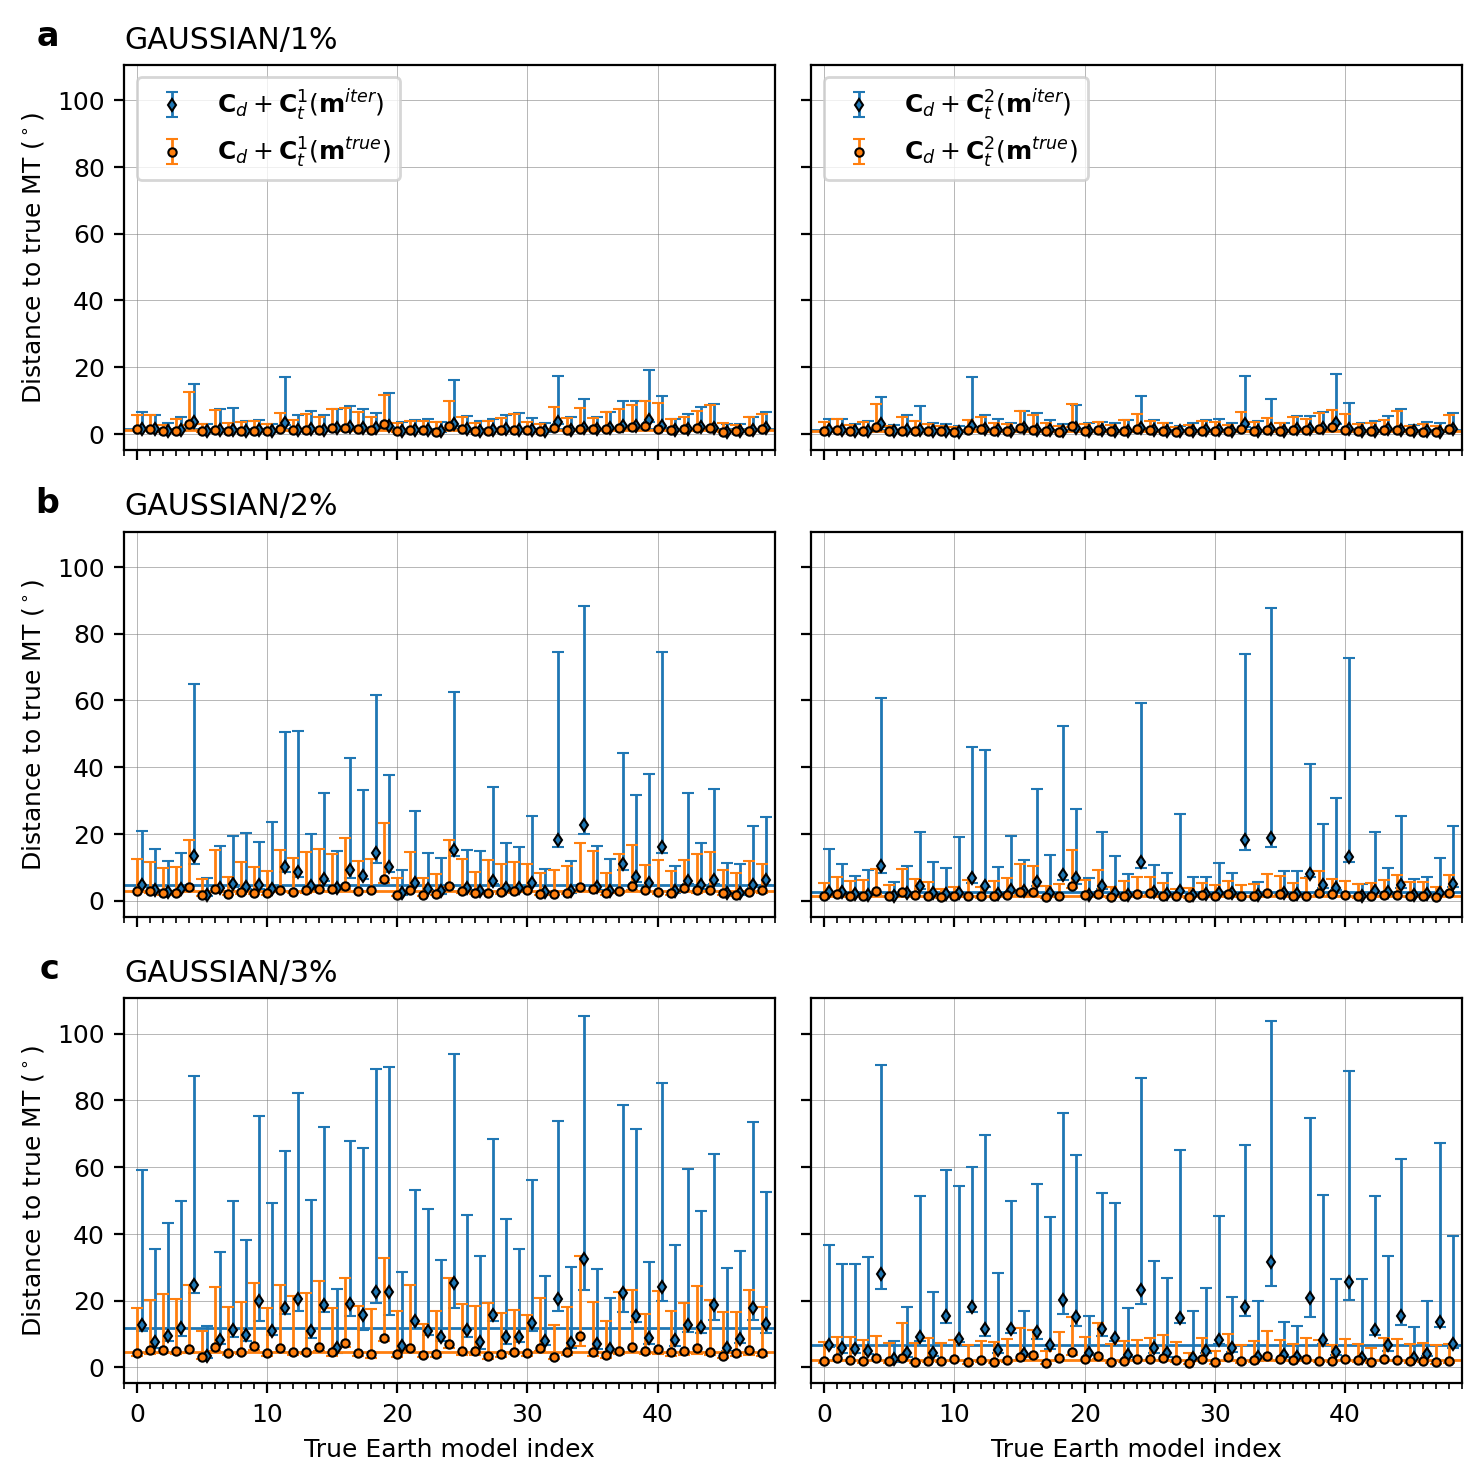

In [ ]:
PlotIntegrationTests(CONFIG_PATHS[6:9])

**Figure 12.** This figure shows the results of a similar analysis as in Fig. 8 but for Gaussian structural error.

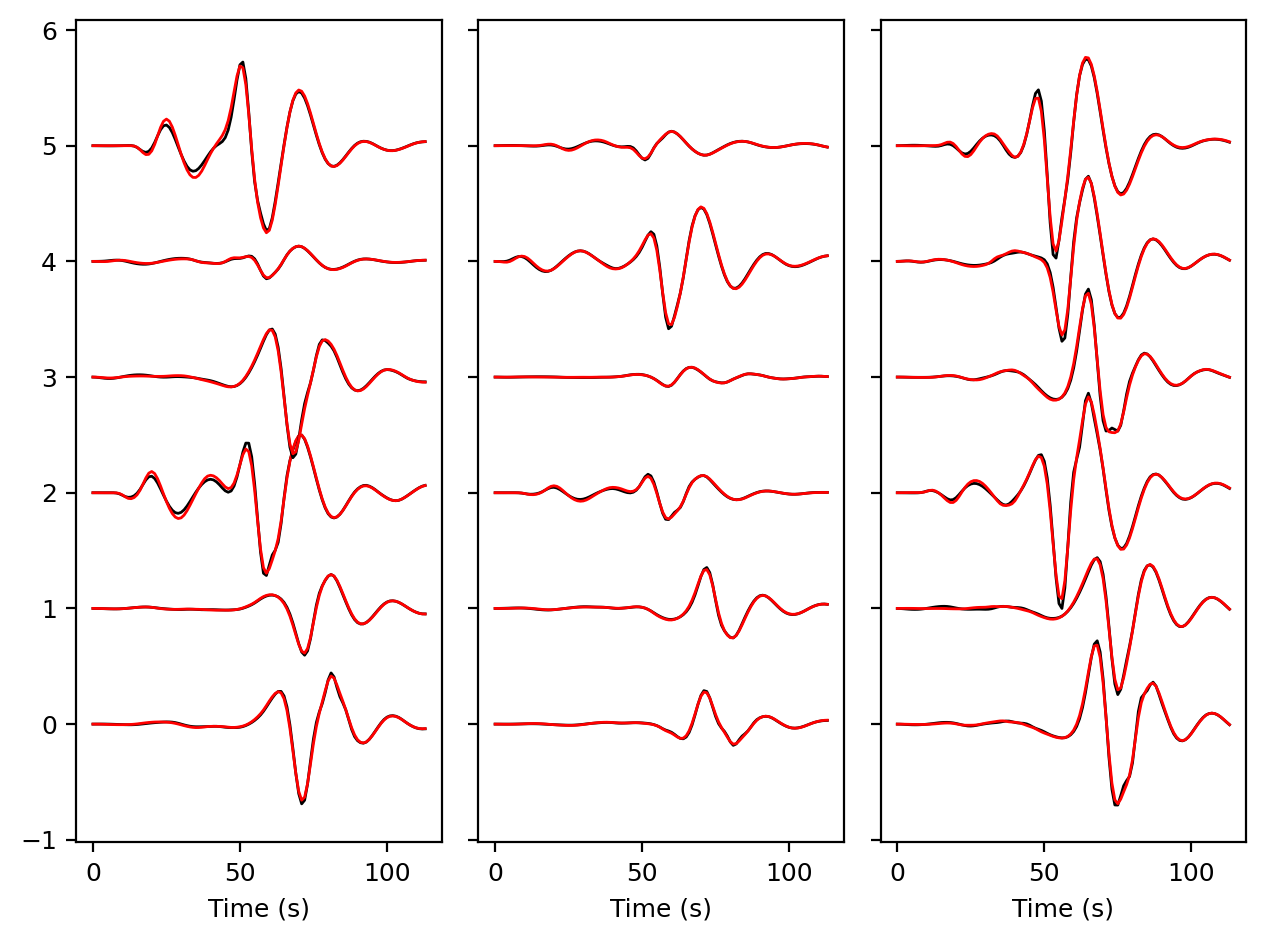

In [ ]:
## Reference models of the known velocity models
gtensor_ref = LoadSES3DGTensor('ses3d_r07_b', vred=VRED, t0=T0, wlen=WLEN)
gtensor_ref = gtensor_ref[STMASK, :, :, :-1]

## predicted waveforms for an isotropic sources
isot = np.array([1, 1, 1, 0, 0, 0]) @ gtensor_ref
clvd = np.array([1/2, 1/2, -1, 0, 0, 0]) @ gtensor_ref
vmax = np.max(np.abs(isot))
isot /= vmax
clvd /= vmax
ns, nc, nt = isot.shape
fig, ax = plt.subplots(1, nc, sharex=True, sharey=True)
for c in range(nc):
    for s in range(ns):
        ax[c].plot(isot[s, c]+s, lw=1, c='k')
        ax[c].plot(clvd[s, c]+s, lw=1, c='r')
    ax[c].set(xlabel='Time (s)')
fig.tight_layout()
plt.show()